In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
from itertools import product
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [2]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
bd_dir = '/Volumes/server/Projects/sfp_nsd/derivatives_old'

results_dir = os.path.join(output_dir, 'sfp_model', 'results_2D', 'nsdsyn')
fig_dir = '/Volumes/server/Projects/sfp_nsd/derivatives/figures'

stim_info_path='/Volumes/server/Projects/sfp_nsd/natural-scenes-dataset/nsdsyn_stim_description.csv'

lr = 0.0005
max_epoch = 30000
dset='nsdsyn'
roi_list = ['V1','V2','V3']
vsc='pRFsize'
subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
args = ['lr','eph','sub','roi','dset']
broderick_sn_list = [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]
broderick_subj_list = [utils.sub_number_to_string(i, 'broderick') for i in broderick_sn_list]


# Import stimulus orientation information

In [3]:
stim_info = vis2D.get_w_a_and_w_r_for_each_stim_class(stim_info_path)

# Import Broderick dataset
## import model parameters

In [4]:
#TODO: same format for broderick files
broderick_file_list = []
bd_file_list = []
for subj in broderick_subj_list:
    f = os.path.join(bd_dir,
                     'sfp_model',
                     'results_2D',
                     f'model_history_dset-broderick_bts-median_full_ver-True_sub-{subj}_lr-0.0005_eph-30000_V1.h5')
    bd_file_list.append(f)
bd_args = ['dset', 'sub']
bd_params = utils.load_history_files(bd_file_list, *bd_args)
bd_params['vroinames'] = 'V1'
bd_params = bd_params.query('epoch == 29999')

## import precisions for each subject

In [5]:
bd_file_list = []
for bd_subj in broderick_subj_list:
    f = os.path.join(output_dir, 'dataframes', 'broderick', 'precision', f'precision-v_dset-broderick_sub-{bd_subj}_roi-V1_vs-pRFsize.csv')
    bd_file_list.append(f)
bd_precision = utils.load_history_files(bd_file_list)
bd_precision_s = bd_precision.groupby(['sub','vroinames'], group_keys=False).mean().reset_index()

final_bd_df = bd_params.merge(bd_precision_s[['sub','vroinames','sigma_v_squared']], on=['sub','vroinames'])

# predict preferred period based on the param values
## relative frame

In [11]:
prediction_bd_df = pd.DataFrame({})
for s in final_bd_df['sub'].unique():
    tmp_params = final_bd_df.query('sub == @s')
    tmp_df = vis2D.calculate_preferred_period_for_synthetic_df(stim_info, tmp_params,
                                                               ecc_range=(0,10), n_ecc=3,
                                                               angle_range=(0,2*np.pi),
                                                               n_angle=360,
                                                               ecc_col='eccentricity',
                                                               angle_col='angle',
                                                               angle_in_radians=True,
                                                               reference_frame='relative')
    col_list = ['sub', 'vroinames', 'dset', 'sigma_v_squared']
    for col in col_list:
        tmp_df[col] = tmp_params[col].item()
    prediction_bd_df = pd.concat((prediction_bd_df, tmp_df), axis=0)

# Import NSD dataset
## import model parameters

In [13]:
pt_file_list = []
for subj, roi in product(subj_list, ['V1','V2','V3']):
    file_name = os.path.join(output_dir,
                             'sfp_model',
                             'results_2D',
                             'nsdsyn',
                             f'model-params_lr-{lr}_eph-{max_epoch}_dset-{dset}_sub-{subj}_roi-{roi}_vs-{vsc}.pt')
    pt_file_list.append(os.path.join(results_dir, file_name))
nsd_params = model.load_all_models(pt_file_list, *args)

## import precisions for each subject

In [14]:
pt_file_list = []
for subj, roi in product(subj_list, ['V1','V2','V3']):
    f = os.path.join(output_dir, 'dataframes', dset, 'precision', f'precision-v_dset-{dset}_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    pt_file_list.append(f)
nsd_precision_v = utils.load_history_files(pt_file_list)
nsd_precision_s = nsd_precision_v.groupby(['sub','vroinames']).mean().reset_index()
final_nsd_df = nsd_params.merge(nsd_precision_s[['sub','vroinames','sigma_v_squared']], on=['sub','vroinames'])

# predict preferred period based on the param values
## relative frame

In [16]:
prediction_nsd_df = pd.DataFrame({})
for s, roi in product(final_nsd_df['sub'].unique(), final_nsd_df['vroinames'].unique()):
    tmp_params = final_nsd_df.query('sub == @s & vroinames == @roi')
    tmp_df = vis2D.calculate_preferred_period_for_synthetic_df(stim_info, tmp_params,
                                                               ecc_range=(0,10), n_ecc=3,
                                                               angle_range=(0,2*np.pi),
                                                               n_angle=360,
                                                               ecc_col='eccentricity',
                                                               angle_col='angle',
                                                               angle_in_radians=True,
                                                               reference_frame='relative')
    col_list = ['sub', 'vroinames', 'dset', 'sigma_v_squared']
    for col in col_list:
        tmp_df[col] = tmp_params[col].item()
    prediction_bd_df = pd.concat((prediction_bd_df, tmp_df), axis=0)

# Combine two datasets

In [18]:
final_df = prediction_bd_df.append(prediction_nsd_df, ignore_index=True)
final_df['precision'] = 1 / final_df['sigma_v_squared']

def dset_roi(row):
    if row.dset == "broderick":
        new_col = 'V1 Broderick'
    else:
        new_col = f'{row.vroinames} NSD'
    return new_col
final_df['dset_roi'] = final_df.apply(dset_roi, axis=1)
final_df.head()

,names,w_r,w_a,eccentricity,angle,local_ori,Pv,sub,vroinames,dset,sigma_v_squared,precision,dset_roi
0,pinwheel,0.0,6.0,0.0,0.0,1.570796,0.386208,wlsubj001,V1,broderick,0.096439,10.369273,V1 Broderick
1,forward spiral,4.0,4.0,0.0,0.0,0.785398,0.407821,wlsubj001,V1,broderick,0.096439,10.369273,V1 Broderick
2,annulus,6.0,0.0,0.0,0.0,0.000000,0.398246,wlsubj001,V1,broderick,0.096439,10.369273,V1 Broderick
3,reverse spiral,4.0,-4.0,0.0,0.0,2.356194,0.407821,wlsubj001,V1,broderick,0.096439,10.369273,V1 Broderick
4,pinwheel,0.0,6.0,5.0,0.0,1.570796,0.729079,wlsubj001,V1,broderick,0.096439,10.369273,V1 Broderick


# Plot preferred period prediction figure
## preferred period as as function of eccentricity

In [19]:
ecc_df = final_df.groupby(['sub','vroinames','names','eccentricity','dset_roi']).mean().reset_index()

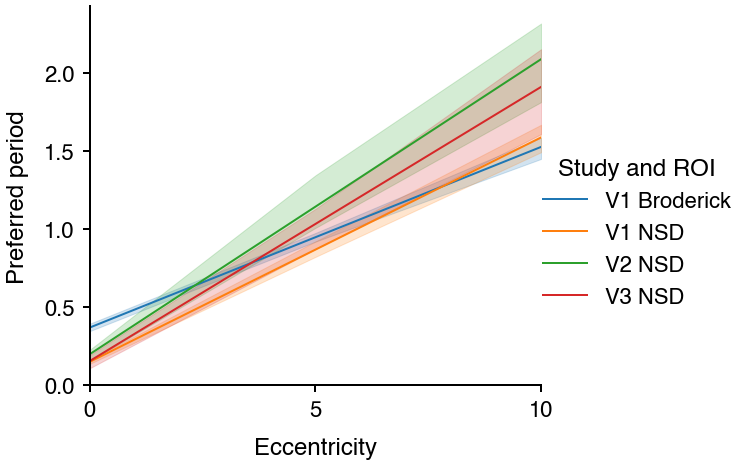

In [147]:
pp_fig = f'fig-pp_x-ecc_lr-{lr}_eph-{max_epoch}_dset-all_sub-all_roi-V1V2V3_vs-{vsc}.png'
vis2D.plot_preferred_period(ecc_df,
                            x='eccentricity', hue='dset_roi',
                            hue_order=['V1 Broderick', 'V1 NSD','V2 NSD','V3 NSD'],
                            lgd_title='Study and ROI',
                            xlim=(0,4),
                            save_path=os.path.join(fig_dir, 'sfp_model', 'prediction_2D',
                                                   pp_fig))

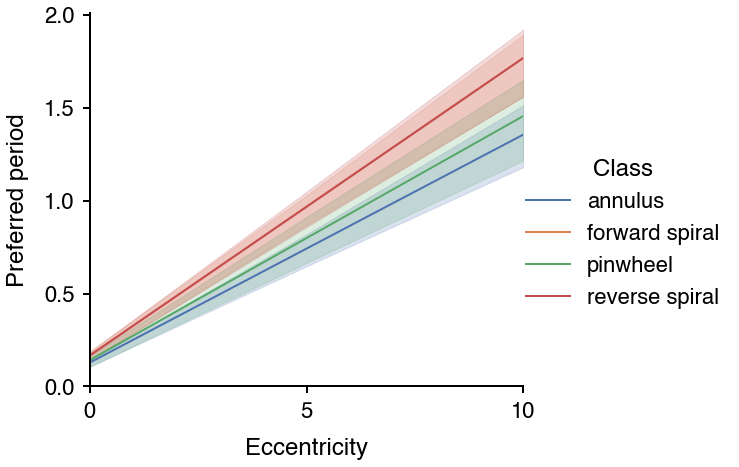

In [22]:
pp_fig = f'fig-pp_x-ecc_lgd-class_lr-{lr}_eph-{max_epoch}_dset-NSD_sub-all_roi-V1_vs-{vsc}.png'
vis2D.plot_preferred_period(ecc_df.query('dset_roi == "V1 NSD"'),
                            x='eccentricity', hue='names',
                            hue_order=['annulus', 'forward spiral','pinwheel','reverse spiral'],
                            lgd_title='Class',
                            xlim=(0,4),
                            save_path=os.path.join(fig_dir, 'sfp_model', 'prediction_2D',
                                                   pp_fig))

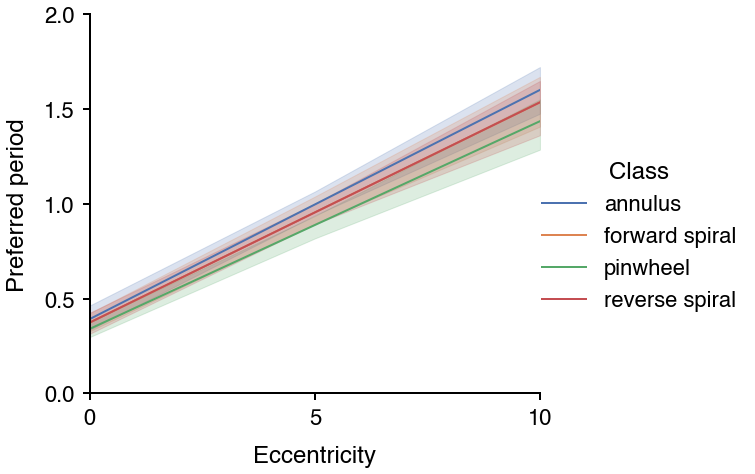

In [23]:
pp_fig = f'fig-pp_x-ecc_lgd-class_lr-{lr}_eph-{max_epoch}_dset-broderick_sub-all_roi-V1_vs-{vsc}.png'
vis2D.plot_preferred_period(ecc_df.query('dset_roi == "V1 Broderick"'),
                            x='eccentricity', hue='names',
                            hue_order=['annulus', 'forward spiral','pinwheel','reverse spiral'],
                            lgd_title='Class',
                            xlim=(0,4),
                            save_path=os.path.join(fig_dir, 'sfp_model', 'prediction_2D',
                                                   pp_fig))